#  House Rental Price Prediction

## Introduction

In this project, we predict house rental price from features extracted from geographical data and house conditions. Given some information about a house, we want to know the price (in US dollars) per night per person. We fetch data from different data sources, including Airbnb, Yelp, Foursquare via different APIs, and extract useful features from them. We divide data into training set, validation set and testing set, on which we explore different regression models. In addition, we also explore using classification models to predict rental price ranges.

We also attempt to apply the model to all the cities as an integrated data set. Since the result is less satisfactory, we changed our target to classifying the listing into different ranges(bins) instead. The retrieved dataset is non-temporal. We only focus on the data at a specific time point.

In [1]:
# Import numerical tools
import numpy as np
import pandas as pd
import math

# Import pickle
import pickle

import requests
from bs4 import BeautifulSoup
import time
import io

# Import plotting tools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.core.pylabtools import figsize

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Problem Formulation
We will predict house rental prices from house listings in [Airbnb](http://www.airbnb.com). This is a typical regression problem. We would like to predict the Airbnb listing price the house owner will set given the features we collected for a house.


## Data Collection

In this section, we collect data points for houses in 100 largest cities listed in [this website](http://www.citymayors.com/gratis/uscities_100.html). We expect that the house rental price is influenced by the location of the house and the conditions of the house. Specifically, location will affect living cost and nearby attractions; House conditions, such as property type, bed type will also influence the rental price. For house conditions, we use the listing information provided by [Airbnb APIs](http://airbnbapi.org/). For geographical conditions, we use [Yelp API](https://github.com/Yelp/yelp-python) and [Fourquare API](https://developer.foursquare.com/) to collect numbers of related businesses around the houses. In addition, we also use python script to scrawl median household income for each city from [city-data.com](http://www.city-data.com/).

### Part I: Collecting Data On House Conditions

We organize the information on house conditions in Table 1.

| | **housing conditions** |
|----------|-------------|
| reviews_count      | number of reviews for the house |
| bathrooms          | number of bathrooms for the house |
| room_type_category | the type of room in the house |
| instant_bookable   | boolean value indicating whether the house is instantly bookable |
| cancellation_policy| the type of cancellation policy for renting the house |
| bedrooms           | number of bedrooms |
| bed_type_category  | the type of bed in the house |
| person_capacity    | maximum number of people allowed to stay |
| property_type      | the house type |
| min_nights         | minimum number of nights required to book the house |  
<center>[Table 1]</center>

### Part II: Collecting Data On Geographical Conditions

We organize the information on geographical conditions in Table 2.

| | **geographical conditions** |
|----------|-------------|
| num_attractions | number of attractions within 1 km radius centered at the house |
| num_food | number of all types of food within 1 km radius centered at the house |
| num_restaurants | number of restaurants within 1 km radius centered at the house |
| num_tours | number of all types of tours within 1 km radius centered at the house |
| num_trainstations | number of train stations within 1 km radius centered at the house |
| num_transport | number of all types of transportation within 1 km radius centered at the house |
<center>[Table 2]</center>

The code for data collection can be found in Appendix: Code for Data Collection.

## Feature Extraction

While most of data fields are numerical, some fields need converting to numerical forms. These fields are converted into one-hot encoding:

*Original Fields*:

| **data field** | **type** | **value** |
|----------------|----------|---------------------|
| room_type_category | categorical | entire_home, private_room, shared_room |
| instant_bookable | boolean | False, True |
| cancellation_policy | categorical | strict, moderate, flexible |
| bed_type_category | categorical | real_bed, futon, pull_out_sofa, couch, airbed |
| property_type | categorical | Bed & Breakfast, Apartment, Loft, Guesthouse, House, Condominium, Townhouse, Entire Floor |

*Converted Fields*:

| **data field** | **type** | **value (original value)** |
|----------------|----------|---------------------|
| entire_home      | numeric  | 0(not entire_home), 1(entire_home)|
| private_room     | numeric  | 0(not private_room), 1(private_room)|
| shared_room      | numeric  | 0(not shared_room), 1(shared_room)|
| instant_bookable | numeric  | 0(False), 1(True) |
| strict           | numeric  | 0(not strict), 1(strict) |
| moderate         | numeric  | 0(not moderate), 1(moderate) |
| flexible         | numeric  | 0(not flexible), 1(flexible) |
| real_bed         | numeric  | 0(not real_bed), 1(real_bed) |
| futon            | numeric  | 0(not futon), 1(futon) |
| pull_out_sofa    | numeric  | 0(not pull_out_sofa), 1(pull_out_sofa) |
| couch            | numeric  | 0(not couch), 1(couch) |
| airbed           | numeric  | 0(not airbed), 1(airbed) |
| Bed & Breakfast  | numeric  | 0(not Bed & Breakfast), 1(Bed & Breakfast) |
| Apartment        | numeric  | 0(not Apartment), 1(Apartment) |
| Loft             | numeric  | 0(not Loft), 1(Loft) |
| Guesthouse       | numeric  | 0(not Guesthouse), 1(Guesthouse) |
| House            | numeric  | 0(not House), 1(House) |
| Condominium      | numeric  | 0(not Condominium), 1(Condominium) |
| Townhouse        | numeric  | 0(not Townhouse), 1(Townhouse) |
| Entire Floor     | numeric  | 0(not Entire Floor), 1(Entire Floor) |

## Dataset Preprocessing

Let's start with loading raw features and prices:

In [2]:
import pickle

def load_data():
    # Load features
    with open('data/features/features4.pkl', 'rb') as handle:
        all_features = pickle.load(handle)

    # Load list of feature names
    with open('data/features/feature_list.pkl', 'rb') as handle:
        feature_list = np.asarray(pickle.load(handle))

    # Load price
    with open('data/prices/prices4.pkl', 'rb') as handle:
        prices = np.asarray(pickle.load(handle))
    
    # Load city names
    with open('data/city_names.pkl', 'rb') as handle:
        city_names = pickle.load(handle)
    return all_features, feature_list, prices, city_names

all_features, feature_list, prices, city_names = load_data()

We would like to start by building seperate models for each city. The median household income will be the same for the data in a city and can be ignored. 

In [6]:
# Get city column
city_col = all_features[:, 12]
# Delete city indexes and median household income
truncated_features = np.delete(all_features, [11, 12], 1)

In [7]:
def split_by_city(features, prices, city_col, num_cities):
    city_features = [all_features[city_col==i, :] for i in range(num_cities)]
    city_prices = [prices[city_col==i] for i in range(num_cities)]
    return city_features, city_prices

city_features, city_prices = split_by_city(truncated_features, prices, city_col, len(city_names))

For numerical stability, we normalize the raw features for each dimension:

In [8]:
from sklearn.preprocessing import normalize

def normalize_features(features):
    """ normalize_features normalizes features for each dimension
        
        Input:
            - features (ndarray)
        Output:
            - normalized features (ndarray)
    """
    return normalize(features, norm='max', axis=0)
    
normalized_city_features = [normalize_features(features) for features in city_features]

We then split the dataset into train set, valid set and test set with ratio of 7:2:1.

In [9]:
class DataSet():
    def __init__(self, tr_X, te_X, val_X, tr_y, te_y, val_y):
        self.tr_X = tr_X
        self.te_X = te_X
        self.val_X = val_X
        self.val_y = val_y
        self.tr_y = tr_y
        self.te_y = te_y

# Constants
TRAIN_PERCENT = 0.7
VALID_PERCENT = 0.2
TEST_PERCENT = 1 - TRAIN_PERCENT - VALID_PERCENT
RANDOM_SEED = 13
TRAIN_CUM = TRAIN_PERCENT
VALID_CUM = TRAIN_CUM + VALID_PERCENT


def split_data(data, price, percent=1.0):
    """ split_data splits data into 3 folds:
        train_X, train_y: TRAIN_PERCENT
        test_X,  test_y:  TEST_PERCENT
        
        Input:
            - data (ndarray): raw features to be split
            - y (ndarray): prices corresponding to raw features
        Output:
            - train_X (ndarray): training raw features
            - test_X  (ndarray): testing raw features
            - train_X (ndarray): training raw features
            - test_X  (ndarray): testing raw features
            - train_y (ndarray): training prices
            - test_y  (ndarray): testing prices
    """
    
    # Shuffle
    idx = np.arange(data.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    data = data[idx]
    price = price[idx]
    
    # Split data into train, and test set
    num_data = len(data)
    test_X   = data[int(num_data*VALID_CUM):]
    test_y  = price[int(num_data*VALID_CUM):]
    
    train_X  = data[:int(num_data*TRAIN_CUM*percent)]
    train_y = price[:int(num_data*TRAIN_CUM*percent)]
    valid_X  = data[int(num_data*TRAIN_CUM*percent):int(num_data*VALID_CUM*percent)]
    valid_y = price[int(num_data*TRAIN_CUM*percent):int(num_data*VALID_CUM*percent)]
    
    return DataSet(train_X, test_X, valid_X, train_y, test_y, valid_y)

city_dataset = [split_data(normalized_city_features[i], city_prices[i]) for i in range(len(city_names))]

## Feature Analysis

Next we visualize the relation between features and rental prices for New York City.

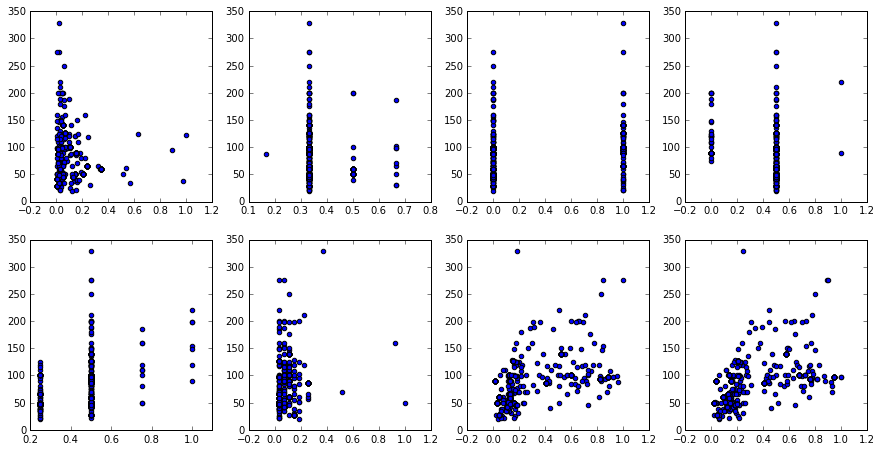

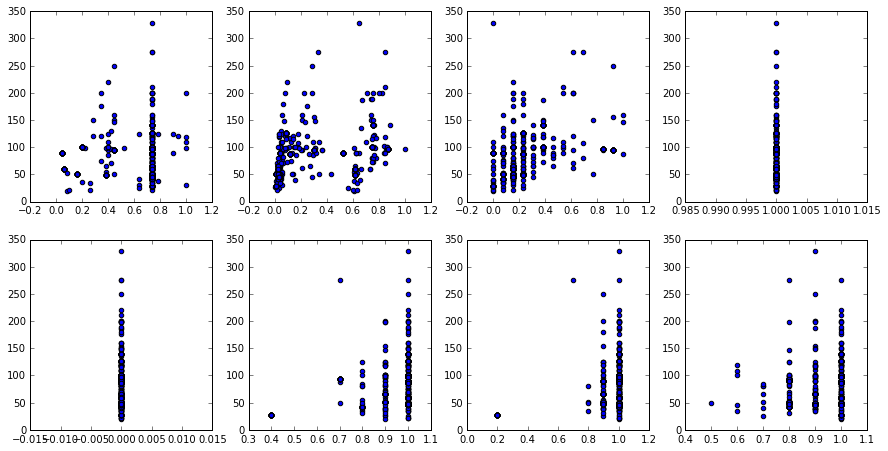

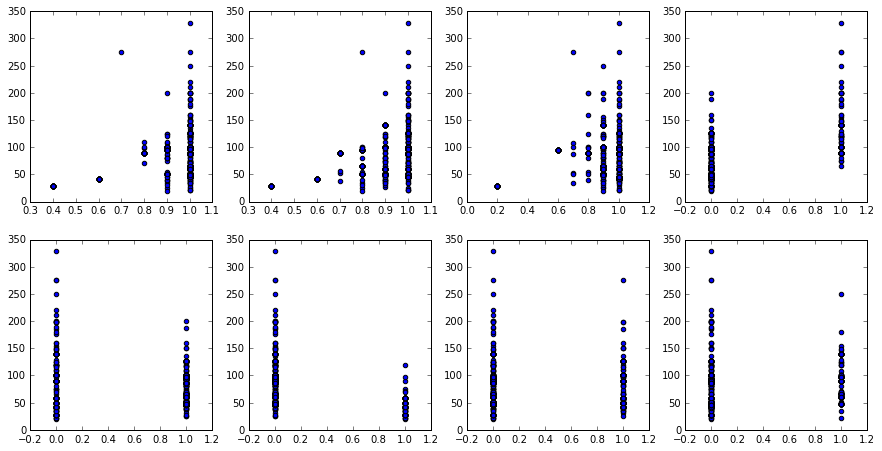

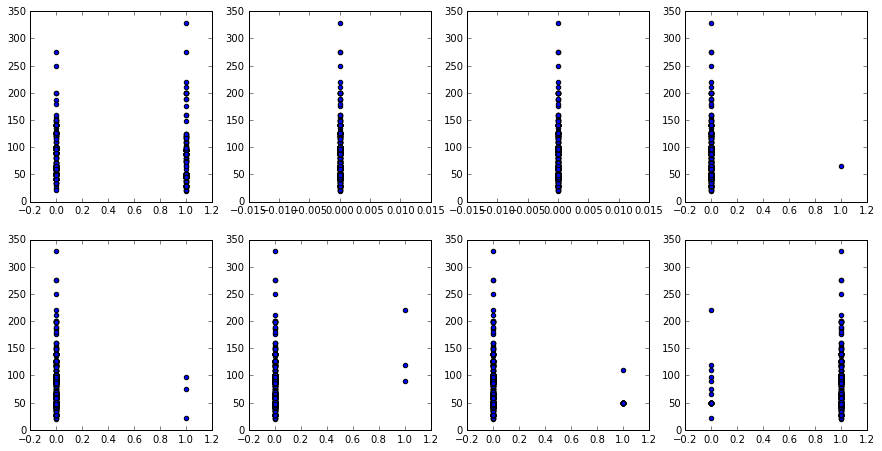

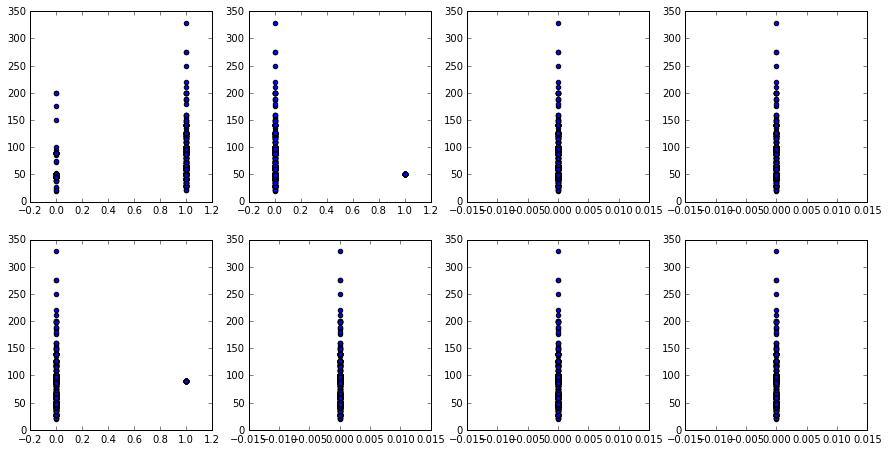

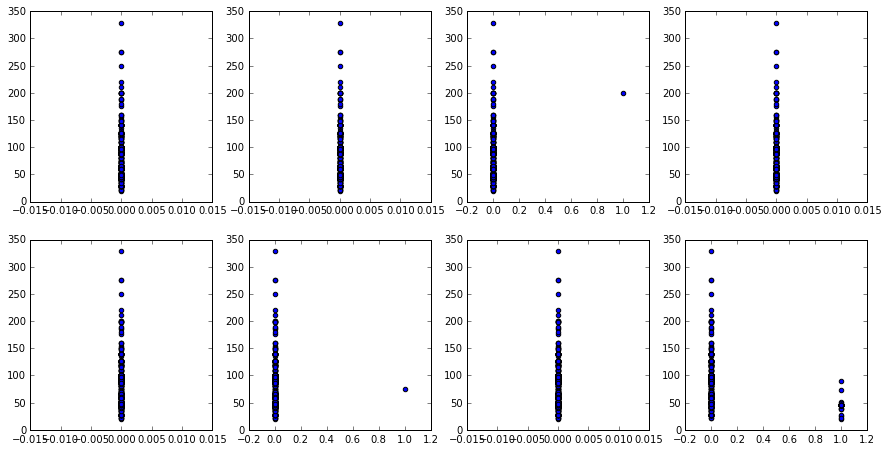

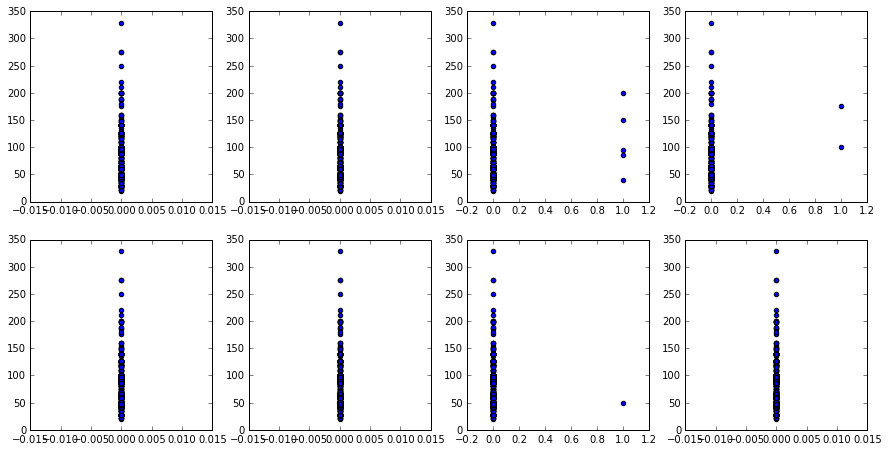

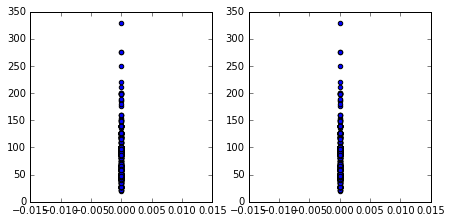

In [34]:
def multi_scatter_plot(X, y):
    """ multi_scatter_plot plots multiple scatter plots,
        each of which is plotted as prices against one
        feature dimension
        
        Input:
            - X (ndarray): features
            - y (ndarray): labels
    """
    figsize(15, 7.5)
    fig_nums = int((X.shape[1] + 8 - 1) / 8)
    for f in range(fig_nums):
        plt.figure(f+1)
        for i in range(8):
            if i+8*f >= X.shape[1]: break
            num = int('24' + str(i+1))
            plt.subplot(num);
            plt.scatter(X[:,i+8*f], y)  


sp_input, sp_output = city_dataset[0].tr_X, city_dataset[0].tr_y
# Plot for the train data of New York City
multi_scatter_plot(sp_input, sp_output)

According to the scatter plot of raw features and the prices, most of them are not strongly correlated. Next, we will transform raw features into RBF features based on the algorithm described in the lecture [[1]](http://www.datasciencecourse.org/nonlinear_modeling.pdf) as see how the relation changes.

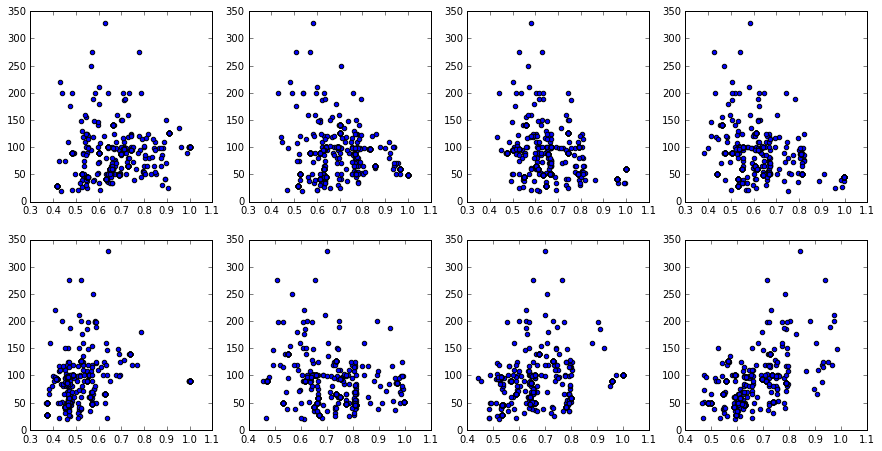

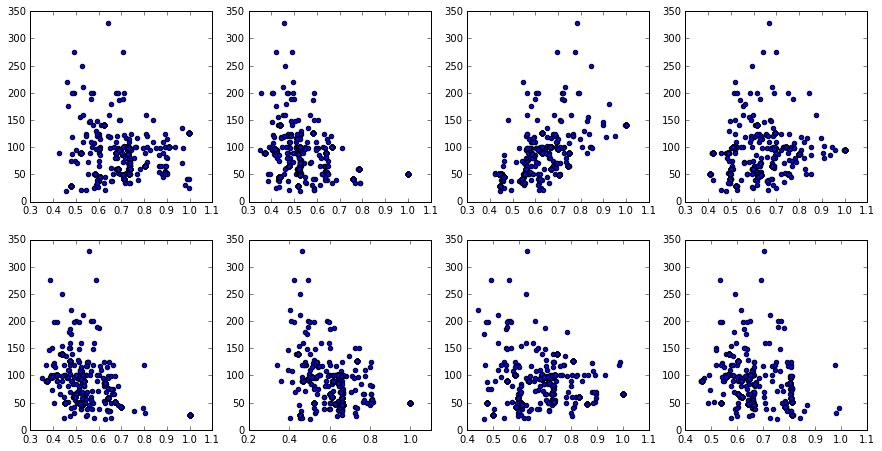

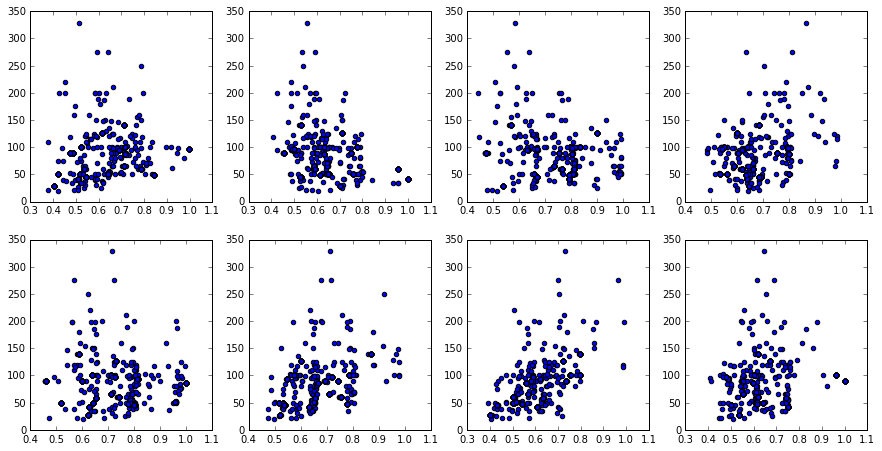

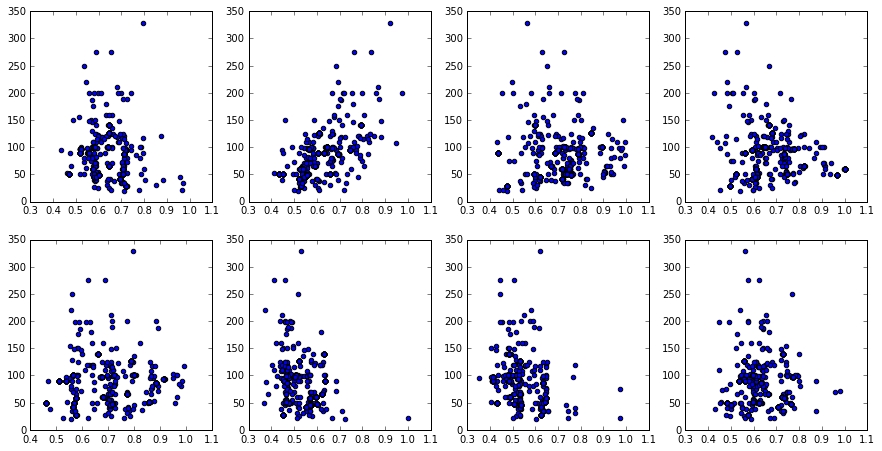

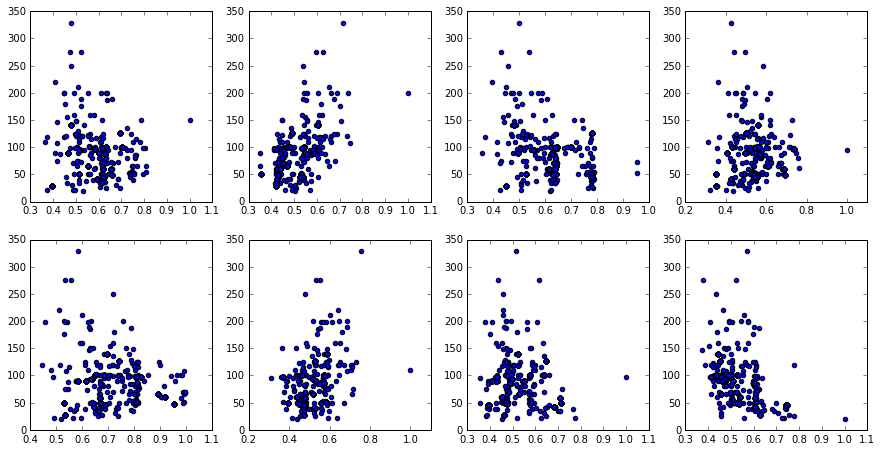

In [72]:
from sklearn.cluster import KMeans

def compute_mu(X, p):
    """ compute_mu uses kmeans to compute p centers """
    kmeans = KMeans(n_clusters=p, random_state=0).fit(X)
    return kmeans.cluster_centers_

def compute_sig(X):
    """ compute_sig uses median trick to find std """
    sqdist = -2*X.dot(X.T) + np.sum(X**2,axis=1)[:,None] + np.sum(X**2,axis=1)
    return np.sqrt(np.median(sqdist))

def rbflize_features(X, p):
    """ rbflize_features converts raw features into RBF features """
    mu = compute_mu(X, p)
    sig = compute_sig(mu)
    sqdist = -2*X.dot(mu.T) + np.sum(X**2,axis=1)[:,None] + np.sum(mu**2,axis=1)
    return np.exp(-sqdist/(2*sig**2))

rbf_features = rbflize_features(sp_input, 40)
multi_scatter_plot(rbf_features, sp_output)

According the plot of rbf features and prices, we can spot several strong correlations, e.g. the plot in row 1 column 4 and row 6 column 4. Therefore, we expect models will perform better with rbf features than with raw features.

## Regression Model

In this section, we explore linear regression and support vector regression model with different kernels. 
We use the following function to report training and testing performance.

In [10]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def evaluate(model, dataset):
    """ evaluate function train the model and return:
        train mean absolute error
        validation mean absolute error
        
        Input:
            - model (Model): model to be evaluated
            - dataset (DataSet): train and test data
        Output:
            - train_error
            - valid_error
            - test error
    """
    tr_X = dataset.tr_X
    tr_y_true = dataset.tr_y
    val_X = dataset.val_X
    val_y_true = dataset.val_y
    te_X = dataset.te_X
    te_y_true = dataset.te_y
    # fit train data into model
    model.fit(tr_X, tr_y_true)
    
    # predict
    tr_y_pred = model.predict(tr_X)
    val_y_pred = model.predict(val_X)
    te_y_pred = model.predict(te_X)
    
    # Print statistics
    tr_err = mean_absolute_error(tr_y_true, tr_y_pred)
    val_err = mean_absolute_error(val_y_true, val_y_pred)
    te_err = mean_absolute_error(te_y_true, te_y_pred)
    
    return tr_err, val_err, te_err


# Evaluation function for a estimator
def eval_est(data, get_est, verbose=False):    
    tr_errs = []
    val_errs = []
    te_errs = []
    for i in range(len(city_names)):
        if verbose:
            print i, city_names[i]
        est = get_est(data[i])
        tr_err, val_err, te_err = evaluate(est, data[i])
        tr_errs.append(tr_err)
        val_errs.append(val_err)
        te_errs.append(te_err)
    return tr_errs, val_errs, te_errs

def report(results, title, test=False):
    tr_errs, val_errs, te_errs = map(np.array, results)
    figsize(10, 8)
    fig = plt.figure()
    ax5 = fig.add_subplot(111)
    CUT_OFF = 40
    # Remove the cities with large train or validation error
    if not test:
        selector = (tr_errs > 0) & (tr_errs < CUT_OFF) & (val_errs > 0) & (val_errs < CUT_OFF)
        ax5.scatter(range(len(tr_errs[selector])), tr_errs[selector], s=20, c='b', marker="o", label='train mae')
        ax5.scatter(range(len(val_errs[selector])), val_errs[selector], s=20, c='r', marker="o", label='valid mae')
    else:
        ax5.scatter(range(len(te_errs)), te_errs, s=20, c='g', marker="o", label='test mae')

    if not test:
        avg_tr_err = np.mean(tr_errs[selector])
        avg_val_err = np.mean(val_errs[selector])
        print "Reporting results for ", sum(selector), " cities"
        print "Avg Train MAE:", avg_tr_err
        print "Avg Valid MAE:", avg_val_err
    else:
        avg_te_err = np.mean(te_errs)
        print "Avg Test MAE:", avg_te_err

    plt.legend(loc='upper left');
    plt.xlabel('city index')
    plt.ylabel('Mean Absolute Error')
    plt.title(title)

### Linear Regression with Raw Features

First, let's directly feed raw features into linear regression model.

Reporting results for  64  cities
Avg Train MAE: 16.9521437623
Avg Valid MAE: 19.0088109947


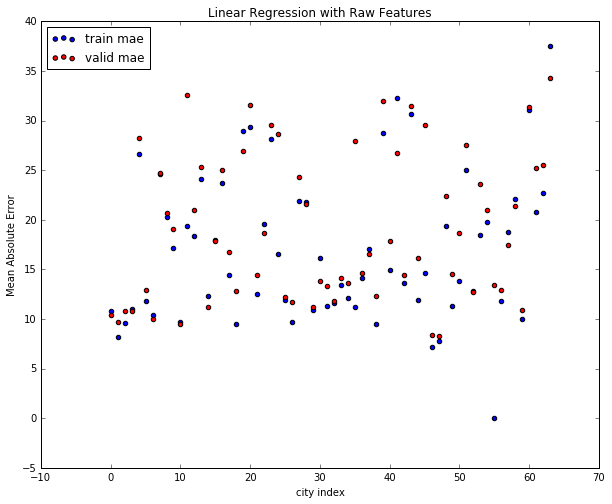

In [36]:
def get_linear(data):
    return linear_model.LinearRegression()

report(eval_est(city_dataset, get_linear), 'Linear Regression with Raw Features')

In report function, we remove the cities with train or test errors larger than a cut off value in order to get a reasonable plot of the errors.  
Even though with many outliers removed, the overall absolute errors are still unsatisfactory. Next, we switch to explore the power of support vector regression model.

### Support Vector Regression

We have learned support vector machine from class. The Support Vector Regression (SVR) uses the same principles as the SVM for classification. The problem can be formulated as

- minimize $\frac{1}{2}\lVert \mathbf{w} \rVert^2 + C \sum_{i=1}^m (\xi_i + \xi^{\star}_i)$

- with constraints for $\forall i = 1, \ldots, m$:
$$y_i - \mathbf{w}^T \mathbf{x} - b \leq \epsilon + \xi_i$$
$$\mathbf{w}^T \mathbf{x} + b - y_i \leq \epsilon + \xi^{\star}_i$$
$$\xi_i, \xi^{\star}_i \geq 0$$

The above formulation finds a function with at most $\epsilon$-deviation from the target. Only points outside the $\epsilon$-deviation range contributes to loss, as illustrated by the following picture.

<img src="images/svr_image.png">

Instead of solving SRV as mentioned above (called primal problem), we mostly solve its dual problem:

- maximize $\frac{1}{2}\sum_{i,j=1}^m (\alpha_i - \alpha^{\star}_i)(\alpha_j - \alpha^{\star}_j) \langle x_i, x_j \rangle - \epsilon \sum_{i=1}^m (\alpha_i + \alpha^{\star}_i) + \sum_{i=1}^m y_i (\alpha_i - \alpha^{\star}_i)$
- with constraints:
$$\sum_{i=1}^m (\alpha_i - \alpha^{\star}_i) = 0,$$
$$0 \leq \alpha_i, \alpha^{\star}_i \leq C$$

Notice we can apply kernel tricks to the term $\langle x_i, x_j \rangle$, i.e. $K(x_i, x_j) = \langle \varphi(x_i), \varphi(x_j) \rangle$, where $\varphi$ can be non-linear function which we don't need to compute explicitly. In addition to linear kernel $K(x_i, x_j) = x_i^T x_j$, there are two commonly used kernels:
1. Polynomial (Poly) kernels: $K(x_i, x_j) = (x_i^T x_j + 1)^d$, where $d$ is the degree of the polynomial
2. Radial basis function (RBF) kernels: $K(x_i, x_j) = \exp\left(-\frac{1}{2\sigma^2} \lVert x_i - x_j \rVert^2\right)$. Note RBF kernels have infinite dimensions.

### Linear SVR

We start with linear SVR some parameters of our choice.

Reporting results for  90  cities
Avg Train MAE: 15.7593743287
Avg Valid MAE: 17.291103187


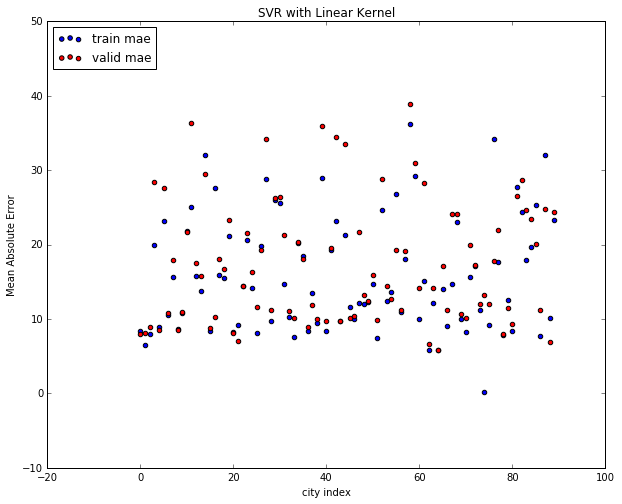

In [38]:
def get_svr_linear(data):
    svr_linear = SVR(C=100.0, epsilon=0.2, kernel='linear')
    return svr_linear
report(eval_est(city_dataset, get_svr_linear), 'SVR with Linear Kernel')

SVR with linear kernel gives less outlier cities and a slightly better average error.

### RBF SVR

Now we try SVR with RBF kernel.

Reporting results for  83  cities
Avg Train MAE: 18.0549472051
Avg Valid MAE: 17.5807976403


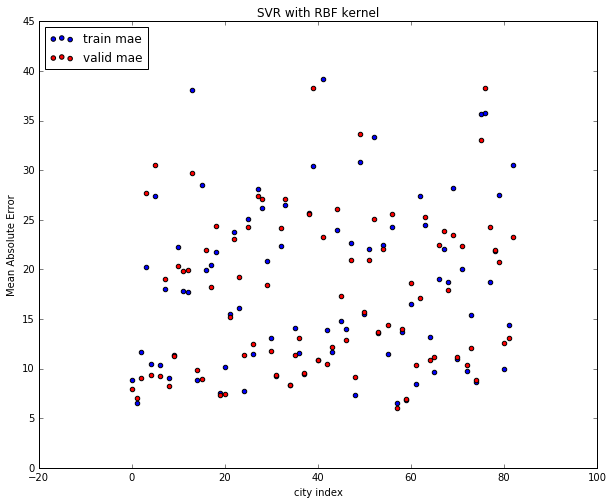

In [15]:
def get_svr_rbf(data):
    svr_rbf = SVR(C=100.0, epsilon=0.2, kernel='rbf')
    return svr_rbf
report(eval_est(city_dataset, get_svr_rbf), 'SVR with RBF kernel')

With the given randomly chosen parameters, SVR with RBF kernel gives slightly worse results as linear kernel.  
Still, both of the models seem to be promising because the parameters are randomly chosen. We would like to search for the best parameters for each model using model selection libraries.

### Search for Optimal Parameters

In [40]:
from sklearn.model_selection import RandomizedSearchCV

def get_best_svr(data):
    parameters = {'kernel':['rbf', 'linear'], 
                  'C':[0.1, 1, 10, 100, 600, 1000, 2000], 
                  'epsilon': [0.001, 0.005, 0.01]}
    svr = SVR()
    # clf = GridSearchCV(svr, parameters)
    n_iter_search = 20
    clf = RandomizedSearchCV(svr, param_distributions=parameters,
                                   n_iter=n_iter_search)
    tr_X, tr_y = data.tr_X, data.tr_y
    clf.fit(tr_X, tr_y)
    print clf.best_estimator_
    return clf.best_estimator_

0 New York City, New York
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
1 Los Angeles, California
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
2 Chicago, Illinois
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
3 Houston, Texas
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
4 Philadelphia, Pennsylvania
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
5 Phoenix, Arizona
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, t

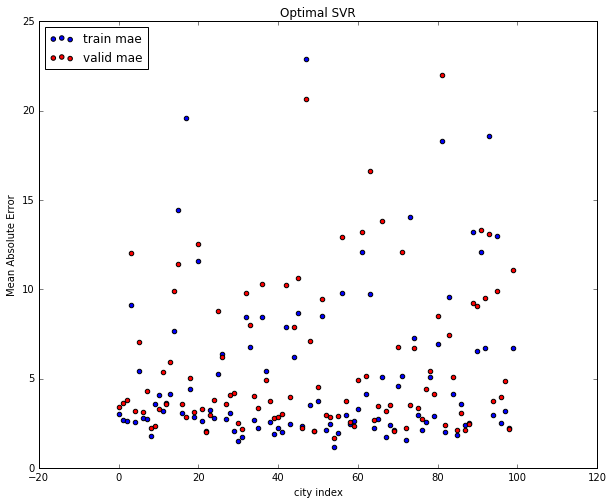

In [62]:
report(eval_est(city_dataset, get_best_svr, True), 'Optimal SVR')

When we print out the parameters of the best estimator selected for each city, we find that almost all the models are using RBF kernel. One of the reasons might be RBF kernel allows for more complex modeling than linear kernels. Next, we try to further reduce the errors using AdaBoost.

### AdaBoost with SVR

0 New York City, New York
AdaBoostRegressor(base_estimator=SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)
1 Los Angeles, California
AdaBoostRegressor(base_estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)
2 Chicago, Illinois
AdaBoostRegressor(base_estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)
3 Houston, Texas
AdaBoostRegressor(base_estimator=SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma

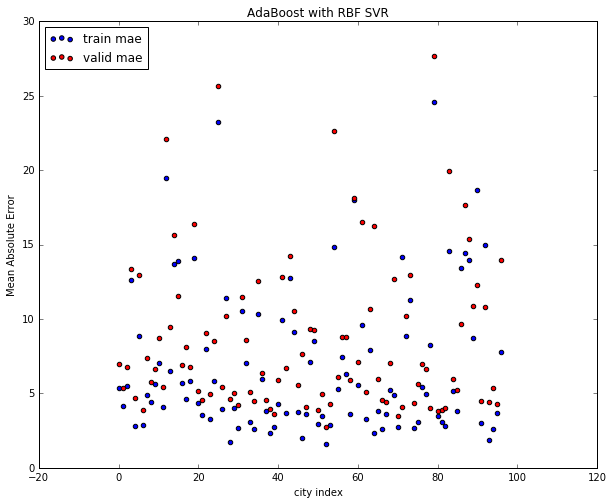

In [63]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

def get_adaboost_svr(data):
    parameters = {'kernel':['rbf'], 
                  'C':[0.1, 1, 10, 100, 600, 1000, 2000],
                  'epsilon': [0.001, 0.005, 0.01]}
    svr = SVR()
    regr = GridSearchCV(svr, parameters)
    tr_X, tr_y_true = data.tr_X, data.tr_y
    regr.fit(tr_X, tr_y_true)
    regr = AdaBoostRegressor(regr.best_estimator_)
    print regr
    return regr
report(eval_est(city_dataset, get_adaboost_svr, True), 'AdaBoost with RBF SVR')

AdaBoost with SVR has worse performance than a single optimal SVR. Thus, we stick to single SVR.

### Scaled prices

When we plot the distribution of prices, we find that there are some extremely high prices:

(array([  7.20540000e+04,   4.50000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    10.,   1009.,   2008.,   3007.,   4006.,   5005.,   6004.,
          7003.,   8002.,   9001.,  10000.]),
 <a list of 10 Patch objects>)

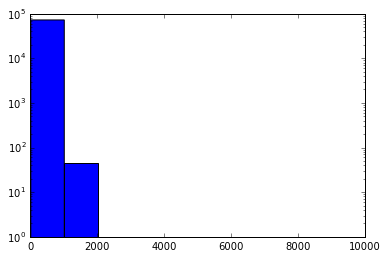

In [88]:
plt.yscale('log', nonposy='clip')
plt.hist(prices)

Some houses seem to have very high prices. The number of houses that have rental prices larger than 200 US dollars is

In [44]:
print sum(prices > 500), "out of", len(prices)

550 out of 72100


By closer examination, we notice that many of these high rental price houses can accommodate more people:

In [45]:
idx = prices > 500
samples = zip(truncated_features[idx, 4], prices[idx])
for i in range(20):
    print i, ": (capacity, price) = ({}, {})".format(int(samples[i][0]), samples[i][1])

0 : (capacity, price) = (4, 575.0)
1 : (capacity, price) = (2, 700.0)
2 : (capacity, price) = (6, 538.0)
3 : (capacity, price) = (16, 1250.0)
4 : (capacity, price) = (1, 10000.0)
5 : (capacity, price) = (7, 800.0)
6 : (capacity, price) = (10, 550.0)
7 : (capacity, price) = (14, 799.0)
8 : (capacity, price) = (10, 600.0)
9 : (capacity, price) = (10, 600.0)
10 : (capacity, price) = (10, 1300.0)
11 : (capacity, price) = (12, 650.0)
12 : (capacity, price) = (2, 600.0)
13 : (capacity, price) = (7, 1000.0)
14 : (capacity, price) = (16, 950.0)
15 : (capacity, price) = (8, 1000.0)
16 : (capacity, price) = (5, 600.0)
17 : (capacity, price) = (6, 650.0)
18 : (capacity, price) = (8, 1000.0)
19 : (capacity, price) = (5, 600.0)


It occurs to us that instead of waiting for the learning algorithm to discover the straightforward relationship of the capacity and the price, we will transform the dataset with this knowledge in mind. Therefore, we divided the prices by the `person_capacity`, and removed the `person_capacity` column.

In [11]:
def trans_per_person(features, prices):
    prices_per_person = prices / features[:, 4]
    reduced_features = np.delete(features, [4], 1)
    return prices_per_person, reduced_features

In [12]:
prices_per_person, reduced_features = trans_per_person(truncated_features, prices)

After transforming the prices into price per person, we can see that the distribution of prices becomes more reasonable:

In [75]:
print sum(prices_per_person > 500), "out of", len(prices_per_person)

3 out of 72100


Now, let's try the optimal SVR with RBF kernel again on the scaled prices.


0 New York City, New York
SVR(C=600, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
1 Los Angeles, California
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
2 Chicago, Illinois
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
3 Houston, Texas
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
4 Philadelphia, Pennsylvania
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
5 Phoenix, Arizona
SVR(C=600, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, t

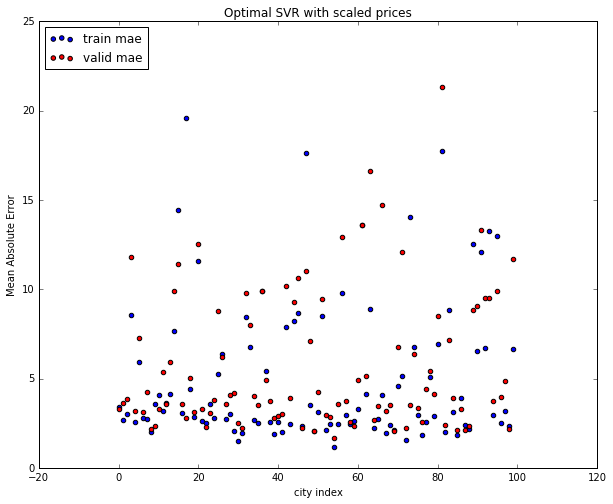

In [64]:
city_features, city_prices = split_by_city(reduced_features, prices_per_person, city_col, len(city_names))
normalized_city_features = [normalize_features(features) for features in city_features]
city_dataset = [split_data(normalized_city_features[i], city_prices[i]) for i in range(len(city_names))]
report(eval_est(city_dataset, get_best_svr, True), 'Optimal SVR with scaled prices')

We observe a significant improvement in train error and validation error. A real-life prediction on a house rental price to be off by 5-6 dollars is considered reasonable. Let's see how it works out on test set:

0 New York City, New York
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
1 Los Angeles, California
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
2 Chicago, Illinois
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
3 Houston, Texas
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
4 Philadelphia, Pennsylvania
SVR(C=2000, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
5 Phoenix, Arizona
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True,

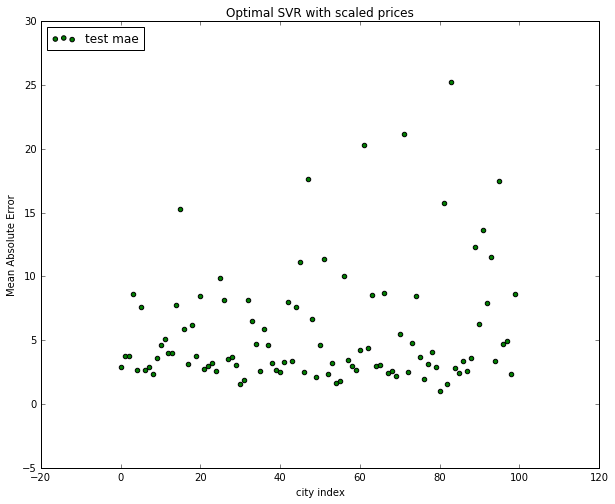

In [42]:
report(eval_est(city_dataset, get_best_svr, True), 'Optimal SVR with scaled prices', True)

We see that the performance on the test set is also good. This means that RBF SVR trained for each city can reasonably predict the house rental price in reality.

### One Regressor for All Cities

Although RBF SVR model performs well, we can only predict for a house listing in a known city (among the 100 cities). We want a model that can predict for a house listing in any city (not restricted to the 100 cities) given sufficient information.

We have also run one RBF SVR on integrated dataset of all cities, and get the following results:
```
Train set mean absolute error: 1.8393
Valid set mean absolute error: 5.4030
Test set mean absolute error: 4.8829
```
[TODO] Since the program runs for a long time, which makes it really hard to try different models, we will not explore this further. Instead, we try to convert the regression problem into a classification problem so that we can predict rental price range for a house.

In [13]:
# We will need to modify our utility functions to work with an integrated dataset
def eval_est_single(data, get_est):
    est = get_est(data)
    tr_err, val_err, te_err = evaluate(est, data)
    print 'Train Error: %.4f' % tr_err
    print 'Validation Error: %.4f' % val_err
    print 'Test Error: %.4f' % te_err
    return est, tr_err, val_err, te_err

In [16]:
percent = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
ests, tr_errs, val_errs, te_errs = [], [], [], []

for p in percent:
    full_dataset = split_data(reduced_features, prices_per_person, percent=p)
    est, tr_err, val_err, te_err = eval_est_single(full_dataset, get_svr_rbf)
    ests.append(est)
    tr_errs.append(tr_err)
    val_errs.append(val_err)
    te_errs.append(te_err)
    
# print type(est)
# print est

Train Error: 0.2001
Validation Error: 8.2315
Test Error: 15.5516
Train Error: 0.1999
Validation Error: 15.9677
Test Error: 15.4809
Train Error: 0.2000
Validation Error: 21.9073
Test Error: 16.0918
Train Error: 1.2552
Validation Error: 15.6612
Test Error: 15.4758
Train Error: 1.4383
Validation Error: 11.7386
Test Error: 14.4536
Train Error: 1.8672
Validation Error: 10.1192
Test Error: 9.7914
Train Error: 1.8250
Validation Error: 7.3725
Test Error: 7.5746
Train Error: 1.7559
Validation Error: 5.1930
Test Error: 5.3462
Train Error: 1.8393
Validation Error: 5.4030
Test Error: 4.8829


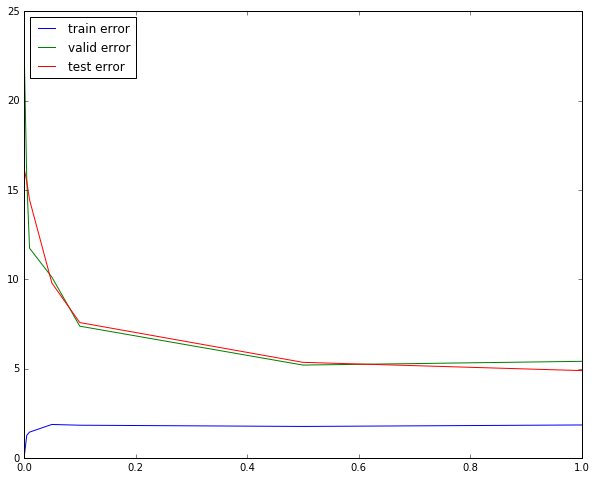

In [19]:
plt.plot(percent, tr_errs)
plt.plot(percent, val_errs)
plt.plot(percent, te_errs)
plt.legend(['train error', 'valid error', 'test error'], loc='upper left')
plt.show()

## Classification

In addition to formulating the house rental price prediction into a regression problem, we also explore binning prices into different buckets (labels) and making it a classification problem.

Due to the large dataset, directly running classification models on it will result in a long time. Instead, we focus on running the models on a subsampled dataset and report the performance of the models on the entire dataset in the end.

The rules we use to select our subsampled dataset are as follows:
- If the city contains no more than 10 data points, include all of them in the subsampled dataset;
- Otherwise, randomly select 10 percent of the city's data points and add them into the subsampled dataset. 

In [50]:
# Subsample features according to cities
def subsample_features(features, prices):
    PERCENT = 0.1
    sub_features = []
    sub_prices = []
    for city in range(100):   
        idx = city_col == city
        city_features = features[idx, :]
        city_prices = prices[idx]
        
        if len(city_features) <= 10:
            sub_features += list(city_features)
            sub_prices += list(city_prices)
        else:
            city_idx = np.arange(len(city_features))
            np.random.seed(RANDOM_SEED)
            np.random.shuffle(city_idx)
            sub_idx = city_idx[:int(PERCENT*len(city_features))]
            sub_features += list(city_features[sub_idx, :])
            sub_prices += list(city_prices[sub_idx])
            
    return np.array(sub_features), np.array(sub_prices)

sub_features, sub_prices = subsample_features(reduced_features, prices_per_person)

This gives a subsampled dataset of size:

In [51]:
print len(sub_prices)

7173


(array([   39.,   273.,   958.,  1289.,  1253.,   887.,   642.,   534.,
          360.,   158.,   236.,   100.,   123.,    45.,    36.,    36.,
           70.,     6.,    13.,    18.]),
 array([   0.,    6.,   12.,   18.,   24.,   30.,   36.,   42.,   48.,
          54.,   60.,   66.,   72.,   78.,   84.,   90.,   96.,  102.,
         108.,  114.,  120.]),
 <a list of 20 Patch objects>)

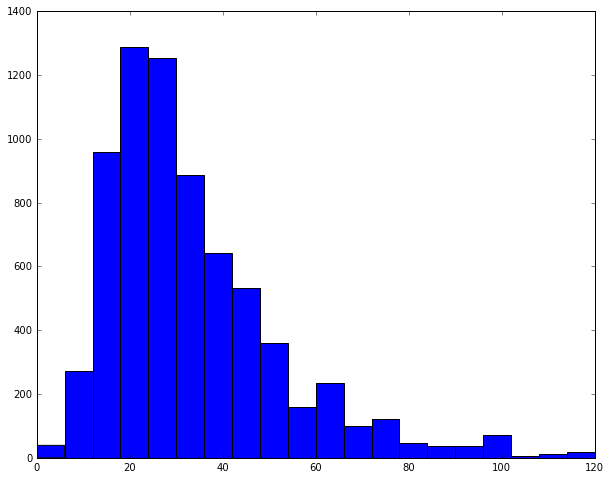

In [52]:
plt.hist(sub_prices, 20, range=[0, 120])

According to the histogram, we decide the bin the prices into a 6 different categories:

In [53]:
def price_to_label(price):
    if price <= 20:
        return 0
    elif price <= 40:
        return 1
    elif price <= 60:
        return 2
    elif price <= 80:
        return 3
    elif price <= 100:
        return 4
    else:
        return 5

def convert_to_labels(prices):
    return np.array(map(price_to_label, prices))

In [54]:
sub_labels = convert_to_labels(sub_prices)

In [55]:
sub_dataset = split_data(sub_features, sub_labels)

We use the following function to report training and testing accuracy:

In [56]:
def clf_report(model, dataset):
    print "Train accuracy: {}".format(np.mean(dataset.tr_y==model.predict(dataset.tr_X)))
    print "Valid accuracy: {}".format(np.mean(dataset.val_y==model.predict(dataset.val_X)))

Simple linear SVC shows the following results:

In [57]:
from sklearn.svm import LinearSVC
start = time.time()
linear_svc = LinearSVC()
linear_svc.fit(sub_dataset.tr_X, sub_dataset.tr_y)
clf_report(linear_svc, sub_dataset)
end = time.time()
print "Time elapsed: {} seconds".format(end-start)

Train accuracy: 0.491137223661
Valid accuracy: 0.493723849372
Time elapsed: 2.86208295822 seconds


Simple RBF SVC shows the following results:

In [58]:
from sklearn.svm import SVC
start = time.time()
rbf_svc = SVC()
rbf_svc.fit(sub_dataset.tr_X, sub_dataset.tr_y)
clf_report(rbf_svc, sub_dataset)
end = time.time()
print "Time elapsed: {} seconds".format(end-start)

Train accuracy: 0.901414060944
Valid accuracy: 0.742677824268
Time elapsed: 5.5448820591 seconds


Simple RBF SVC without any parameter tuning gives astonishing results. Now we look for the best RBF SVC using randomized search:

In [59]:
from sklearn.model_selection import RandomizedSearchCV

def search_for_best_svc(dataset):
    parameters = {'kernel':['rbf'], 
                  'C':[0.1, 1, 10, 100, 500, 1000, 10000], 
                  'gamma':[0.01, 0.02, 0.03, 0.04]}
    svc = SVC()
    n_iter_search = 20
    clf = RandomizedSearchCV(svc, param_distributions=parameters,
                                   n_iter=n_iter_search)
    clf.fit(dataset.tr_X, dataset.tr_y)
    return clf.best_estimator_

In [60]:
start = time.time()
classif = search_for_best_svc(sub_dataset)
clf_report(classif, sub_dataset)
end = time.time()
print "Time elapsed: {} seconds".format(end-start)

Train accuracy: 0.984266082454
Valid accuracy: 0.796373779637
Time elapsed: 174.421206951 seconds


We can see that the best RBF SVC gives really high accuracy on train set and slightly lower accuracy on validation set, indicating overfitting. Let's see how it performs on test set:

In [63]:
print "Test accuracy: {}".format(np.mean(sub_dataset.te_y==classif.predict(sub_dataset.te_X)))

Test accuracy: 0.785515320334


And if we apply the method to the entire dataset, we can achieve:
```
Train accuracy: 0.978165246681
Valid accuracy: 0.837228656634
Test accuracy: 0.839134655388
```
Although the model is overfitting, the performance on test set is still acceptable. This means that we can predict house rental price range in a reasonable sense.

## Conclusion

In this project, we explore both regression models and classification models in predicting house rental price.  
We started with training regression models for each city. RBF SVR with tuned parameters gives good performance. We also find it important to apply our knowledge about the dataset and preprosess the data in a way that lays less burden on the machine learning algorithm, as we can see from the significant improvement when we change the prediction target to prices per person. Although we have achieved good result on the regression problem, one drawback of our regressor is that we can only predict the rental prices if they are located in one of the 100 cities we collected data from.[TODO need to change]  
Since it takes too long to train a unified regression model for all cities, we take a step back and try to get a unified classifier that is able to predict the price range, we use simple RBF SVC model to obtain pretty accurate house rental price range.

##  References
1. Prof. Kolter's lecture slide: http://www.datasciencecourse.org/nonlinear_modeling.pdf

## Acknowledgement
We would like to thank Prof. Zico Kolter. The lectures are really helpful and offer us an insight into how to solve real data science problems. We also want to thank TAs. You provide such interesting homeworks and actively answered our questions on Piazza.

## Appendices
### [Table and Figures](http://nbviewer.jupyter.org/github/jerryzh168/15688-proj/blob/master/Table%20and%20Figures.ipynb)

### Data Pipeline
Phase 1: collect housing condition data from Airbnb. ([code](https://github.com/mallocanswer/house-rental-price-prediction/blob/master/phase_i.py))

Phase 2: collect geographical data from Yelp and Foursquare. ([code](https://github.com/mallocanswer/house-rental-price-prediction/blob/master/phase_ii.py))

Phase 3: collect median household income for each city and associate it to corresponding house data. ([code](https://github.com/mallocanswer/house-rental-price-prediction/blob/master/phase_iii.py))

Phase 4: transform the collected data and store as a numpy array. ([code](https://github.com/mallocanswer/house-rental-price-prediction/blob/master/phase_iv.py))